<a href="https://colab.research.google.com/github/Justworkname/6367_project/blob/main/ViT_Grad_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vit CFar Transfer

## Import

In [ ]:
!pip install -q torchinfo

In [ ]:
!pip install pillow

In [ ]:
import torch
import torchvision
import torch.optim as optim
from torch import nn
from torchvision import datasets, transforms
from torchvision.datasets.folder import has_file_allowed_extension
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
from torchinfo import summary
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4033, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4033 (delta 1067), reused 1097 (delta 996), pack-reused 2809
Receiving objects: 100% (4033/4033), 649.59 MiB | 25.25 MiB/s, done.
Resolving deltas: 100% (2358/2358), done.
Updating files: 100% (248/248), done.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'6 16 2023 Meeting.gslides'
 6367
'7 12 2023 meeting.gslides'
 7340
'8 17 2023 meeting.gslides'
'8 30 2023 meeting.gslides'
'9 06 2023 meeting - Bar chart 1.gsheet'
'9 06 2023 meeting - Column chart 1 (1).gsheet'
'9 06 2023 meeting - Column chart 1 (2).gsheet'
'9 06 2023 meeting - Column chart 1.gsheet'
'9 06 2023 meeting.gslides'
'9 20 2023 meeting.gslides'
'9 28 2023 meeting.gslides'
'AI in Breast Cancer in Medical Imaging.gslides'
 AI_MB
 AI_MB_3D
'Colab Notebooks'
 customTF2
 Data_Vision_Transformer
 fakeImages
 Grad_documents
'Invited Lecture 2.gdoc'
'Invited Lecture 5.gdoc'
 Invited_lecture_oct_10.gdoc
'Invited Lecture October 3rd.gdoc'
'Invited Lecture September 19th.gdoc'
'My Drive'
'Presentation Evaluation sep 19.gdoc'
 Seminar
 Ultrasound_Images
 Undergrad_documents
'Veterinary Clinic Tumor Estimation Conclusion.gslides'
'Wild Magic.gsheet'


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Hyper parameters

In [ ]:
# Transfer learning
# 2 classes?
# add grad cam
# pytorch lightning
num_epochs=5
batch_size=1
img_size=224
in_channels=3 #RGB
patch_size=28
embedding_dim=784 ## 384*7 maybe
head=49 # flash attention # heads per feature is 64 embeding dim/64,32,16
dropout=0.1
hidden_size=3136 # 4 times embeiding dimesions
layers = 8
num_classes=15 # will be over written in data phase

## Data

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

In [ ]:
# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

Load

In [ ]:
# Load the CSV file into a DataFrame
csv_file_path = '/content/gdrive/MyDrive/Data_Vision_Transformer/Data_Entry_2017_IM1.csv'
df = pd.read_csv(csv_file_path)

all_classifications = df['Finding Labels'].str.split('|').explode()
unique_classes = all_classifications.unique()
num_unique_classes = len(unique_classes)
num_classes=num_unique_classes

# Just for test
#print(f"There are {num_unique_classes} unique classes in the dataset.")

# Path to the folder containing images
image_folder = '/content/gdrive/MyDrive/Data_Vision_Transformer/images/'
image_data = []
classifications_data = []

for index, row in df.head(250).iterrows():
    image_file_name = row['Image Index']

    # Full path
    image_path = image_folder + image_file_name

    try:
        img = Image.open(image_path)
        img = img.resize((IMG_SIZE, IMG_SIZE))
        #RGBA->RGB noticed some issue with and will fix later
        img = img.convert('RGB')
        img_array = np.array(img)
        image_data.append(img_array)
        # Extract classification and other information from the DataFrame
        classifications = row['Finding Labels'].split('|')[0]
        classifications_data.append(classifications)

    except Exception as e:
        print(f"Error processing {image_file_name}: {str(e)}")
        sys.exit('Image not Found')

image_data = np.array(image_data)
classifications_data = [np.array(classifications) for classifications in classifications_data]

In [ ]:
classifications_data = np.array(classifications_data)

x_train, x_test, y_train, y_test = train_test_split(image_data, classifications_data, test_size=0.2, random_state=42, shuffle=True)

y_train = np.array(y_train)
y_test = np.array(y_test)
plt.imshow(x_train[1,:,:,:])

In [ ]:
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer

# Create a MultiLabelBinarizer
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

index_to_label = {index: label for index, label in enumerate(le.classes_)}
print(index_to_label)

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test_encoded.shape}")

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# x_test and y_test are not NumPy arrays
y_train =np.array(y_train_encoded)
y_test = np.array(y_test_encoded)
# normalize
x_train_input = (x_train /255.0)
x_test_input = (x_test /255.0)
##
y_train_tensor = torch.from_numpy(y_train)
x_train_input = torch.from_numpy(x_train_input)
y_test_tensor = torch.from_numpy(y_test)
x_test_input = torch.from_numpy(x_test_input)
x_train_input=x_train_input.permute(0,3,1,2)
print(x_train_input.shape)
x_test_input=x_test_input.permute(0,3,1,2)
y_test_tensor_new=[scalar.unsqueeze(0) for scalar in y_test_tensor]
y_test_tensor_new = torch.stack(y_test_tensor_new)
# to float
x_train_input=x_train_input.float()
x_test_input=x_test_input.float()
y_test_tensor_new=y_test_tensor_new.float()
y_train_int=y_train_tensor.int()
# Create a PyTorch dataset from the tensors
train_dataset= list(zip(x_train_input,y_train))
test_dataset = TensorDataset(x_test_input, y_test_tensor)
###

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

In [ ]:
for batch in train_dataset:
    data, labels = batch  # Assuming each batch contains data and labels
    print("Data shape:", data.shape)
    print("Labels:", labels)

## Import VGG 19

In [ ]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

## VGG19

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)

        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
# initialize the VGG model
vgg = VGG()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 77.9MB/s]


In [ ]:
vgg19(pretrained=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Grad

In [ ]:
import numpy as np

Predicted class: 969


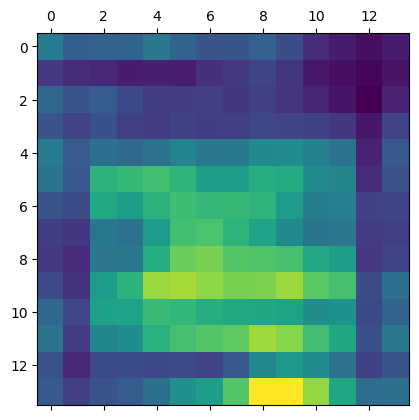

In [ ]:
vgg.eval()

# Define a loss function, for example, CrossEntropyLoss
loss = nn.CrossEntropyLoss()

with torch.enable_grad():
    img, _ = next(iter(test_dataloader))
    pred = vgg(img)
# Sum the 'pred' tensor to make it a scalar
scalar_output = pred.sum()

# Perform backward pass on the scalar output
scalar_output.backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=-1)

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# Assuming 'heatmap' is a CUDA tensor
heatmap = heatmap.to('cpu').numpy()

# relu on top of the heatmap
heatmap = np.maximum(heatmap, 0)

# Convert the NumPy array back to a PyTorch tensor
heatmap = torch.from_numpy(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# Add an extra dimension to convert it into a 2D tensor
heatmap = heatmap.unsqueeze(0)

# Assuming pred is the output of your model
predicted_class = torch.argmax(pred, dim=1)

# Convert the result to a Python integer
predicted_class = predicted_class.item()

# The 'predicted_class' variable now holds the predicted class (as an integer)
print("Predicted class:", predicted_class)
# Draw the heatmap
plt.matshow(heatmap.squeeze())
plt.show()

In [ ]:
import cv2
# Import the necessary libraries
from PIL import Image
from numpy import asarray
# Convert 'img' to a NumPy array
img = asarray(img)
img=img.squeeze()
heatmap_1 = heatmap.cpu().numpy()  # Convert to NumPy array
print(img.shape)
# Resize 'img' and 'heatmap_1' to have the same dimensions
height, width = img.shape[1], img.shape[2]

heatmap_2 = heatmap_1.transpose(1,2,0)
heatmap_3 = cv2.resize(heatmap_2, (width, height))

# Convert the heatmap to an 8-bit unsigned integer (uint8)
heatmap_4 = np.uint8(255 * heatmap_3)
img_1=img.transpose(1,2,0)
print(img_1.shape)
# Superimpose the resized heatmap on the original image using addition
mask = np.stack((heatmap_3,)*3, axis=-1)
threshold = 0.5
mask[mask < threshold] = 0

blended = img_1 * mask

(3, 224, 224)
(224, 224, 3)


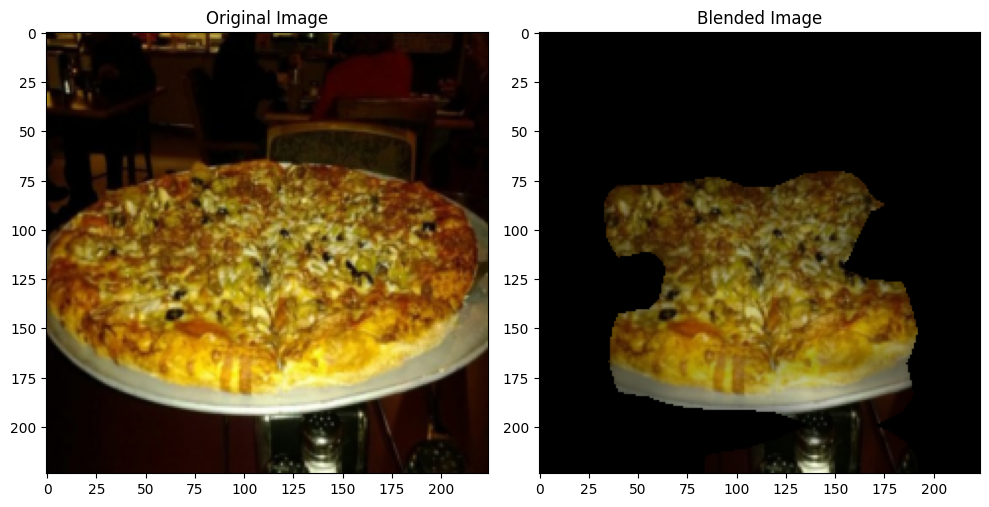

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have img_1 and blended images

# Create a figure with two subplots, one for each image
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

# Plot the first image in the first subplot
plt.subplot(1, 2, 1)
plt.imshow(img_1)
plt.title("Original Image")

# Plot the blended image in the second subplot
plt.subplot(1, 2, 2)
plt.imshow(blended)
plt.title("Blended Image")

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()